# Gaussian Process on the concrete UCI dataset, using Inducing Points and all points

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/concrete.ipynb # Run the toy notebook which is in the datasets folder(toy dataset)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 21.1 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixtur

# Training/Test data from concrete.ipynb

In [3]:
# Set a seed for reproducibility
np.random.seed(52)

concrete_data = df_Concrete # df_Concrete is defined in ../datasets/concrete.ipynb
x, y = concrete_data.iloc[:, :-1].to_numpy() , concrete_data.iloc[:, -1].to_numpy()  # The last column is output(concrete compressive strength)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)
# Normalize training points
xTrain_mean = xTrain.mean(axis = 0) # mean for each feature
xTrain_std = xTrain.std(axis = 0) # std for each feature
yTrain_mean = yTrain.mean() # mean for output
yTrain_std = yTrain.std() # std for output
xTrain = (xTrain-xTrain_mean) / xTrain_std
yTrain = (yTrain-yTrain_mean) / yTrain_std

# Normalize test points
xTest_mean = xTest.mean(axis = 0) # mean for each feature
xTest_std = xTest.std(axis = 0) # std for each feature
yTest_mean = yTest.mean() # mean for output
yTest_std = yTest.std() # std for output
xTest = (xTest-xTest_mean) / xTest_std
yTest = (yTest-yTest_mean) / yTest_std

# Convert them to tensors
xTrain = torch.from_numpy(xTrain).float()
yTrain = torch.from_numpy(yTrain).float()

xTest = torch.from_numpy(xTest).float()
yTest = torch.from_numpy(yTest).float()

print(xTrain.size(), yTrain.size(), xTest.size(), yTest.size())

torch.Size([927, 8]) torch.Size([927]) torch.Size([103, 8]) torch.Size([103])


# The GP model

In [4]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [6]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 250


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [7]:
%time train(model, xTrain, yTrain)

CPU times: user 35.3 s, sys: 622 ms, total: 36 s
Wall time: 42 s


# The posterior mean, variance and Covariance Matrix

In [8]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([103])

Variance Dimension:  torch.Size([103])

CovMatrix Dimension  torch.Size([103, 103])


# Predictive Distribution

In [12]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [13]:
yTest = yTest.numpy() # Convert to numpy

squared_error = (mean - yTest)**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

root_MSE

0.33850010714606726

# Compare different amount of points

In [52]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  timeList = []
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = torch.tensor(x[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(y[:points]) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    time = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    timeList.append(time.all_runs) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([5, 25, 50, 100, 200, 400, 600, 900, 1030]) # With 1030 being all points



Inducing Points:  5
500 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  25
504 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  50
903 ms ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  100
694 ms ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  200
1.45 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  400
4.7 s ± 373 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  600
12 s ± 395 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  900
17.8 s ± 573 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  1030
25.2 s ± 598 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot The Different Times

([<matplotlib.axis.XTick at 0x7b77effe5ab0>,
 [Text(1, 0, '5'),
  Text(2, 0, '25'),
  Text(3, 0, '50'),
  Text(4, 0, '100'),
  Text(5, 0, '200'),
  Text(6, 0, '400'),
  Text(7, 0, '600'),
  Text(8, 0, '900'),
  Text(9, 0, 'All')])

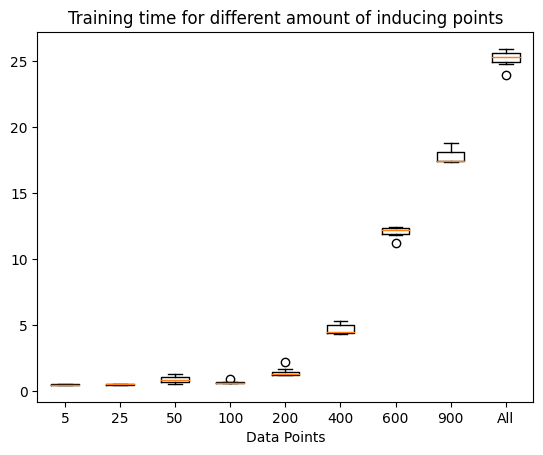

In [53]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')

plt.boxplot(timeList)
plt.xticks([1,2,3,4,5,6,7,8,9],[5, 25, 50, 100, 200, 400, 600, 900, "All(1030)"])

In [58]:
!git commit -m "plot t"